# PART 1
## Webscraping Toronto's Wikipedia page
In this section, we download the content of the Wikipedia page about Toronto neighborhoods and postal codes ([link])(https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) to populate a DataFrame

In [2]:
#imports used in this stage
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

Using `requests.get()` to get the contents of the page, and parsing it with BeautifulSoup. We also print the page title to check if we have accessed the correct page:

In [3]:
tor_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
htmldata = requests.get(url=tor_url).text
soup = BeautifulSoup(htmldata, 'lxml')
print(soup.title)

<title>List of postal codes of Canada: M - Wikipedia</title>


We count the number of tables, and print the beginning of each table to see which of them is the one that we want:

In [4]:
tables = soup.find_all('table')
print('There are {:} tables in the document.'.format(len(tables)))
# printing the beginning of each table to see which one is the right one
_ = [print(tables[i].prettify()[:250]) for i in range(len(tables))]

There are 3 tables in the document.
<table cellpadding="2" cellspacing="0" rules="all" style="width:100%; border-collapse:collapse; border:1px solid #ccc;">
 <tbody>
  <tr>
   <td style="width:11%; vertical-align:top; color:#ccc;">
    <p>
     <b>
      M1A
     </b>
     <br/>
     <
<table class="navbox">
 <tbody>
  <tr>
   <td style="width:36px; text-align:center">
    <a class="image" href="/wiki/File:Flag_of_Canada.svg" title="Flag of Canada">
     <img alt="Flag of Canada" data-file-height="600" data-file-width="1200" decodi
<table cellspacing="0" style="background-color: #F8F8F8;" width="100%">
 <tbody>
  <tr>
   <td style="text-align:center; border:1px solid #aaa;">
    <a href="/wiki/Newfoundland_and_Labrador" title="Newfoundland and Labrador">
     NL
    </a>
   </t


From the sample, we can see that the correct table is found in `tables[0]`.

Once the table is identified, we parse its contents, while also getting rid of undesired data:
- Postal codes that were not assigned yet
- Extraneous characters such as **`( ) /`** and extra whitespaces

In [5]:
neigh_tbl = tables[0]
neigh_lst = []
for val in (neigh_tbl.find_all('td'))[:-1]:
    strtmp = val.get_text(strip=True, separator=';')
    strlist = strtmp.replace('/', ',').split(';')
    # restrict the parsing only to the postal codes already assigned, otherwise skip
    if strlist[1] != 'Not assigned':
        post = strlist[0]
        bor = strlist[1]
        # merge contents of the other cells (neighborhoods)
        nei = ' '.join(strlist[2:])
        # parsing to remove extraneous symbols
        nei = nei.replace('( ', '').replace('(', '').replace(' ,', ',').replace(')', '')
        # removing spaces at the beginning and the end of the string
        nei = nei.lstrip().rstrip()
        strtmp = [post, bor, nei]
        neigh_lst.append(strtmp)

Once the list is correctly parsed, we convert it to a pandas DataFrame:

In [6]:
# convert the resulting list to a pandas DataFrame
df = pd.DataFrame(neigh_lst, columns=['Postal code', 'Borough', 'Neighborhoods'])
df.head()

,Postal code,Borough,Neighborhoods
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Checking DataFrame size

In [7]:
df.shape

(103, 3)

# PART 2
## Getting Latitude and Longitude of the Postal Codes

We obtained the Latitude and Longitude values from ArcGIS using `geocoder`

In [8]:
#imports
!pip install geocoder
import geocoder
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm  # Color palettes
from sklearn.cluster import KMeans  # ML library

In [9]:
# Open previously saved DataFrame, or create a new one and save a local copy
fname = 'Toronto Neighborhoods.csv'

if os.path.exists(fname):
     print("File '{}' already exists. Loading from cache...".format(fname))
     df = pd.read_csv(fname, index_col=0)
else:
     #create a copy of the DataFrame using Postal Code as index
     df2 = df.set_index('Postal code')
     df2['Latitude'], df2['Longitude'] = 0, 0

     # add latitude and longitude using geocoder
     for p in df2.index:
          reply = geocoder.arcgis('ON {}, Canada'.format(p))
          #print(reply, reply.latlng)
          df2.loc[p, ['Latitude', 'Longitude']] = reply.latlng

     print("There are {} missing coordinates after the query".format(sum([df2['Latitude'].isna().sum(),
          df2['Longitude'].isna().sum()])))
     # restore numerical index and Postal Code column
     df = df2.reset_index()
     # save results to a file
     df.to_csv(fname)
     print("DataFrame saved as '{}'.".format(fname))


File 'Toronto Neighborhoods.csv' already exists. Loading from cache...


Checking borough names and shape of the resulting DataFrame

In [10]:
print(df.Borough.unique())
df.shape

['North York' 'Downtown Toronto' "Queen's Park" 'Etobicoke' 'Scarborough'
 'East York' 'York' 'East Toronto' 'West Toronto' 'Central Toronto'
 'Mississauga']


(103, 6)

# PART 3
## Clustering the neighborhoods using data from the Foursquare API
We kept the same parameters from the Manhattan sample exercise, and reused the function ```getNearbyVenues``` from it

In [11]:
{"tags": ["hide-cell",]}
#foursquare credentials
CLIENT_ID = 'L2LRCN30Z5RRWFLVVZVWHPL1JTUF05IZ3IAMMRZX40MU0TIF' # your Foursquare ID
CLIENT_SECRET = '01SEKO1V4WEHUQSEX0QJJ0FVKCIWBOEWFXXWU4OBUWLW5WQU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [12]:
# function to get nearby venues and export to a DataFrame
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append(
            [(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], 
            v['venue']['location']['lng'], v['venue']['categories'][0]['name'])
            for v in results]
            )
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods', 'Neighborhood Latitude', 'Neighborhood Longitude',
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

    return(nearby_venues)

To save time and queries from the Foursquare API, we save the previous results in a file. In case the file is detected, it is loaded from disk instead of executing the query.

In [13]:
fname = 'Toronto Venues.csv'
if os.path.exists(fname):
    print('File "{}" exists, loading from cache'.format(fname))
    venues = pd.read_csv(fname, index_col=0)
else:
    venues = getNearbyVenues(df.Neighborhood, df.Latitude, df.Longitude)
    venues.to_csv(fname)

print('Dataframe shape:', venues.shape)

File "Toronto Venues.csv" exists, loading from cache
Dataframe shape: (2294, 7)


Some of the venues from FSQ are actually neighborhood names, dropping....

In [14]:
venues = venues[~(venues['Venue Category'] == 'Neighborhood') ]
venues.shape

(2288, 7)

There are several similar categories (for example, **Café** vs **Coffee Shop**, **History Museum** vs **Museum**). We have tried to reduce the number of categories a bit. This was not exaustive, we just adjusted the obvious redundancies. Some other categories could probably be dropped altogether (**Intersection** and **Bridge** for example).

In [15]:
print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

replacements = [['Café', 'Coffee Shop'], ['History Museum', 'Museum'], ['Golf Driving Range', 'Golf Course'],
                ['Gym', 'Gym & Fitness Center'], ['Gym / Fitness Center', 'Gym & Fitness Center'], ['Gym Pool', 'Pool'],
                ['Taiwanese Restaurant', 'Thai Restaurant'], ['Art Gallery', 'Art Gallery / Art Museum'], 
                ['Art Museum', 'Art Gallery / Art Museum'], ['Opera House', 'Concert Hall'], ['Jazz Club', 'Music Venue'],
                ['Korean BBQ Restaurant', 'Korean Restaurant'], ['Basketball Stadium', 'Stadium'], ['College Stadium','Stadium'],
                ['Bus Line', 'Public Transp. (bus/rail/metro)'], ['Bus Station', 'Public Transp. (bus/rail/metro)'],
                ['Metro Station', 'Public Transp. (bus/rail/metro)'], ['Light Rail Station', 'Public Transp. (bus/rail/metro)'],
                ['Bar', 'Pubs and Bars'], ['Beer Bar', 'Pubs and Bars'], ['Cocktail Bar', 'Pubs and Bars'],
                ['Gastropub', 'Pubs and Bars'], ['Hotel Bar', 'Pubs and Bars'], ['Irish Pub', 'Pubs and Bars'],
                ['Pub', 'Pubs and Bars'], ['Sake Bar', 'Pubs and Bars'], ['Sports Bar', 'Pubs and Bars'],
                ['Wine Bar', 'Pubs and Bars'], ['Food Court', 'Street Food'], ['Food Truck', 'Street Food'],
                ['Garden', 'Gardens'], ['Sculpture Garden', 'Gardens']]

for r in replacements:
    venues.loc[venues['Venue Category'] == r[0], 'Venue Category'] = r[1]
print('Number of unique categories after grouping: {}'.format(len(venues['Venue Category'].unique())))

There are 264 unique categories.
Number of unique categories after grouping: 238


Here we decided to implement a small modification from the Manhattan example. We use the log2(sum()) instead of mean() to "devalue" the places that have too many of something (for example, coffee shops). The reasoning behind that is that when someone is looking for some service in their neighborhood, they would usually care if there is none, a few, or lots of it. 

In [16]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix='', prefix_sep='')
df_onehot = pd.concat([venues[['Neighborhoods']], onehot],
                      axis=1)
# df_onehot = df_onehot.groupby('Neighborhoods').mean().reset_index()
df_onehot = df_onehot.groupby('Neighborhoods').sum().reset_index()
df_onehot.shape
df_onehot.set_index('Neighborhoods', inplace=True)

df_onehot_linear = df_onehot.copy()
print(df_onehot.shape)

(101, 238)


Here's a graphical illustration of the rationale behind applying log2 to the data:

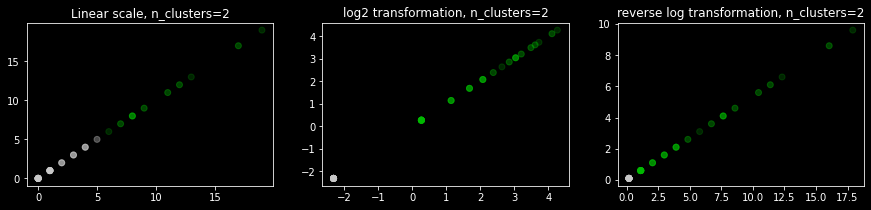

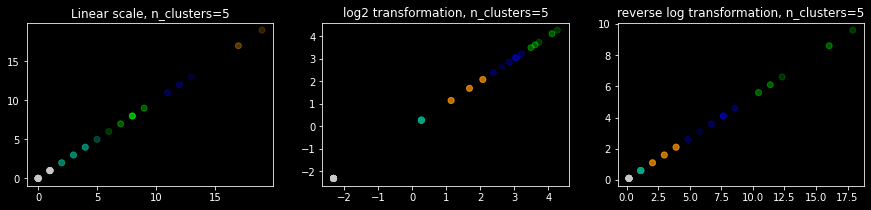

In [17]:
def plot_clusters(n_clusters):
    # define color palette for the plot
    colors = cm.nipy_spectral(np.linspace(0, 1, n_clusters + 1))[::-1]
    # create plot window
    plt.figure(figsize=(15, 3))
    # generate fit and first plot
    cl = KMeans(init='k-means++', n_clusters = n_clusters, random_state=80)
    arr = np.array([df_onehot_linear['Coffee Shop'].values, df_onehot_linear['Coffee Shop'].values]).T
    cl.fit(arr)
    plt.subplot(1, 3, 1)
    plt.scatter(arr[:, 0], arr[:, 1], color=colors[cl.labels_], alpha=.2)
    plt.title('Linear scale, n_clusters={}'.format(n_clusters))
    # generate fit and second plot
    df_onehot2 = np.log2(.2 + df_onehot_linear)
    cl = KMeans(init='k-means++', n_clusters = n_clusters, random_state=80)
    arr = np.array([df_onehot2['Coffee Shop'].values, df_onehot2['Coffee Shop'].values]).T
    cl.fit(arr)
    plt.subplot(1, 3, 2)
    plt.scatter(arr[:, 0], arr[:, 1], color=colors[cl.labels_], alpha=.2)
    plt.title('log2 transformation, n_clusters={}'.format(n_clusters))
    # reverse log transformation to linearize the results
    plt.subplot(1, 3, 3)
    plt.scatter(2**(arr[:, 0] -.1), 2**(arr[:, 1] - 1), color=colors[cl.labels_], alpha=.2)
    plt.title('reverse log transformation, n_clusters={}'.format(n_clusters))

plot_clusters(2)
plot_clusters(5)

The example above shows two different cluster sizes, ```n=2``` and ```n=5```. For ```n=2```, in the linear case groups 0 to 5 coffee houses in the same group, and 6 - 19 in the other group. If we use ```log2``` to transform the data, it differentiates between 0 and any value greater than 1. If we define ```n=5```, in the linear case, it still groups 0 and 1 in the same cluster, whereas if we use the ```log2``` transform, the neighbourhoods with no coffee shops are in a separate group, so this transform helps to distinguish the groups as, for example, *"None", "One", "A few", "Several"* and *Plenty*.

In [18]:
#Applying log2 transform to the data
df_onehot = np.log2(.1 + df_onehot)

Here we generate the *Top 10* most common venues in each neighborhood

In [19]:
top10list = []
for i in range(len(df_onehot)):
    top10local = df_onehot.iloc[i].sort_values()[::-1]
    top10local = (list(top10local[top10local > 0].index.values) + 10*[""])[:10]
    top10list.append(top10local)

top10list = pd.DataFrame(top10list, index=df_onehot.index, columns=range(1, 11))
top10list.head()

,1,2,3,4,5,6,7,8,9,10
Neighborhoods,,,,,,,,,,
Agincourt,Chinese Restaurant,Bubble Tea Shop,Discount Store,Supermarket,Bakery,Badminton Court,Sushi Restaurant,Shopping Mall,Hong Kong Restaurant,Grocery Store
"Alderwood, Long Branch",Convenience Store,Performing Arts Venue,Gym & Fitness Center,Pubs and Bars,,,,,,
Bayview Village,Trail,Construction & Landscaping,Park,Golf Course,,,,,,
"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sandwich Place,Comfort Food Restaurant,Juice Bar,Sushi Restaurant,Indian Restaurant,Thai Restaurant,Pubs and Bars,Sports Club
Berczy Park,Pubs and Bars,Coffee Shop,Seafood Restaurant,Bakery,Pharmacy,Farmers Market,Breakfast Spot,Cheese Shop,Restaurant,Clothing Store


## Clustering the neighborhoods by similarity

Now we use *K-means* to find similar neighborhoods in Toronto city.

In [20]:
#imports
import numpy as np
import folium  # Plotting maps with overlays
import branca   # Fancy HTML text inside bubbles

In [21]:
n_clusters = 20
cl = KMeans(init='k-means++', n_clusters = n_clusters, random_state=80, n_init=100)
cl.fit(df_onehot[df_onehot.columns[:10]])
print(cl.labels_)

[ 0  0  0  0 13  0  9  3  8  0  0  0 18  0 10  0  0  1  0  0  0  0  0  0
  0  0  0  0  2  0  0  0 17  0  2  0  0  0 11  0  0  0  0  0  0  0  0 12
  5  4  0  0 16  0  0  0  0  0  0  0  0  0  0  0  4 14  0  0 17  0  0  0
  0  0  0  7 15  0  0  3  6  0  8  0  0  0  0 15  0  0  0  0  0  7  5  0
  0  0  0  0  0]
<ipython-input-21-f9d39a58cc8a>:3: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  cl.fit(df_onehot[df_onehot.columns[:10]])


Assembling a DataFrame with the neighborhood data and top 10 most common venues


In [22]:
neighborhoods_ranked = df[df.columns[-3:]].set_index('Neighborhoods').sort_index()
neighborhoods_ranked['Cluster'] = np.NaN
neighborhoods_ranked[top10list.columns] = ""

print(len(df_onehot))
for idx in range(len(df_onehot)):
    neighborhoods_ranked.loc[df_onehot.index[idx], 'Cluster'] = cl.labels_[idx]
    neighborhoods_ranked.loc[df_onehot.index[idx], top10list.columns] = top10list.iloc[idx]
#neighborhoods_ranked

101


Here we plot the neighborhood's markers grouped by color.

In [45]:
colors = cm.nipy_spectral(np.linspace(0, 1, n_clusters))

reply = geocoder.arcgis('Toronto, ON, Canada')
reply.latlng
# we added a small correction in latlng to allow for greater zoom
map_toronto = folium.Map(location=list(reply.latlng + np.array([.075, 0])), zoom_start=11)

# add markers to map
for lat, lng, label, cidx, top in zip(neighborhoods_ranked['Latitude'], neighborhoods_ranked['Longitude'], neighborhoods_ranked.index.values, cl.labels_, neighborhoods_ranked[neighborhoods_ranked.columns[3:]].values):
    cv = (255*colors[cidx]).astype('int')
    chex = '#{:02x}{:02x}{:02x}'.format(cv[0], cv[1], cv[2])
    l = ('<b>Group {:}:</b><br><i>{:}:</i><br>{:}, {:}, {:}, {:}, {:}, {:}, {:}, {:}, {:}, {:}').format(cidx, label, top[0], top[1], top[2], top[3], top[4], top[5], top[6], top[7], top[8], top[9])
    # print(l)
    lbl = branca.element.IFrame(l, width=250, height=130)
    label = folium.Popup(lbl)#, parse_html=True)
    folium.CircleMarker([lat, lng], radius=6, popup=label, color='black', weight=1, fill=True, fill_color=chex, fill_opacity=1,
    parse_html=True).add_to(map_toronto)

map_toronto

In [39]:
reply.latlng + np.array([.05, 0])
# reply.latlng + [.05, 0]

array([ 43.69869, -79.38544])